# Changes in CB1 receptor availability in PTSD 

Cannabinoid receptor 1 (CB1r) play a crucial rule in the development and maintenance of trauma related disorders such as Posttraumatic stress disorder (PTSD).

CB1r are the most common g-coupled receptors in the brain and are expressed in all regions of the brain. They act as retrograde messenger and affect excitatory as well as inhibitory synapse.

Previous studies in both humans and rodents showed inconclusive results, with studies showing both up-regulation and down-regulation of CB1r following traumatic event. 

Here, using the 11c-Omar Radio-tracer, we aim to compare differences between healthy controls and PTSD in CB1 receptor availability.

Previous studies have pointed to possible age and sex  effect on CB1r expression.
Hence, both age and sex were introduced as covariance in the analysis.

Our first goal was to look at the entire brain, and see if there is a brain level effect.

To that aim, we run a one way ANCOVA with distribution volume (VT) as dependent and group as independent variable, and sex and age as covariates. 

Using OLS regression, we will verify the effects, and check for which model describe the data best by comparing AIC and BIC.

In the next stage we will check for correlation between CB1r availability and PTSD symptoms.

For that aim we will run partial correlation between CB1r Vt and total PTSD symptoms. Based on results from the first analysis, age and/or sex will be used as covariates.

In the final stage we will look at the Amygdala as an a-priori ROI and look at how CB1r in the Amygdala correlate with PTSD symptoms. We will partial out the whole brain signal, age and/or sex.

## Loading libraries

In [1]:
import pandas as pd
from glob import glob

import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set(rc={'figure.figsize':(8,8)})

# Load data and prepare it for analysis

In [2]:
# Gather VT data from storage@Yale 

hc_path = '/media/Data/Lab_Projects/CB1/neuroimaging/CB1_results/OMAR_scores/dcd/HC/*/batch_omar_doneon_*.csv'

db = pd.DataFrame()

for sub in glob(hc_path):
    temp = pd.read_csv(sub)
    temp = temp[temp['Parameter']== 'VT']
    subID = temp.PatientID[0]
    temp = temp[['ROI', 'Value']]
    temp = temp.rename(columns={'Value': subID})
    temp = temp.set_index('ROI')
    temp = temp.T
    db = db.append(temp)
    
db['group'] = 'HC'

In [3]:
# Load the PTSD data including the clinical data.

PTSD = pd.read_csv('CB1_clinical_30_6_21.csv')
PTSD = PTSD.set_index('PetID')
PTSD = PTSD[PTSD['PTSD'] == 'Yes']

PTSD_bg = PTSD.iloc[:, 11:]
PTSD_bg['group'] = 'PTSD'

db = db.append(PTSD_bg)

In [4]:
# get age and gender as recorded in the Haven data base

age = pd.read_csv('/home/nachshon/Documents/CB1/PETdata/age.csv')
age = age.set_index('PatientID')
data = db.merge(age , left_index=True, right_index=True)

In [5]:
# based on average ROI volume in mm3 caculate whole brain signal
data['whole_brain'] = data.frontal*0.39 + data.temporal*0.265 + data.occipital*0.126 + data.cerebellum*0.11 + data.parietal*0.109
PTSD['whole_brain'] = PTSD.frontal*0.39 + PTSD.temporal*0.265 + PTSD.occipital*0.126 + PTSD.cerebellum*0.11 + PTSD.parietal*0.109

# include only relevant fields for streamlining analysis
wb = data[['group', 'sex', 'age','whole_brain']]
wb['Sex'] = wb['sex'].map({'f':1, 'm':0})
wb['Group'] = wb['group'].map({'PTSD':1, 'HC':0})

wb = wb.drop_duplicates()

/tmp/ipykernel_101712/1047725218.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb['Sex'] = wb['sex'].map({'f':1, 'm':0})
/tmp/ipykernel_101712/1047725218.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb['Group'] = wb['group'].map({'PTSD':1, 'HC':0})


## Sample description

In [6]:
wb[['group','sex','age']].groupby(['group','sex']).count()

age
group sex     
HC    f      7
      m     21
PTSD  f      7
      m      6

In [7]:
wb.groupby(['group'], as_index=False).agg(['mean','std'])

age            whole_brain                 Sex           Group  \
            mean        std        mean       std      mean       std  mean   
group                                                                         
HC     28.750000  10.644508    1.521542  0.206936  0.250000  0.440959   0.0   
PTSD   42.307692  13.567023    1.283803  0.211652  0.538462  0.518875   1.0   

            
       std  
group       
HC     0.0  
PTSD   0.0

In [8]:
wb.groupby(['sex'], as_index=False).agg(['mean','std'])

age            whole_brain            Sex          Group          
          mean        std        mean       std mean  std      mean       std
sex                                                                          
f    33.000000  13.817492    1.448039  0.289559  1.0  0.0  0.500000  0.518875
m    33.074074  13.035236    1.445188  0.206202  0.0  0.0  0.222222  0.423659

### Descriptive notes 

Our sample consist of a total of 41 (13 PTSD), this gives us more statistical power, but also pose 2 limitations. The PTSD sample consist of higher ratio of females to males and a higher average age.

The higher female/male ratio in the PTSD group is representative of the general population.

There appear to be no difference between females and males in age or CB1r availability.

## Age effects and CB1r

In [9]:
pg.ttest(wb[wb['group']=='PTSD']['age'],wb[wb['group']=='HC']['age'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.1775,19.144468,two-sided,0.004924,"[4.63, 22.48]",1.166526,12.974,0.923502


In [10]:
pg.corr(wb.age, wb.whole_brain, method='bicor')

,n,r,CI95%,p-val,power
bicor,41,-0.39486,"[-0.63, -0.1]",0.010622,0.739278


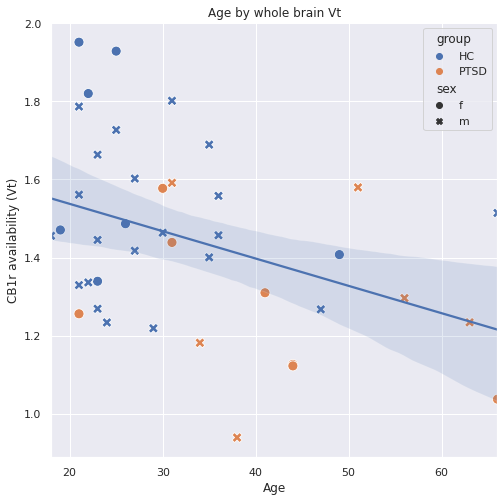

In [11]:
# Plot the relation between Age and CB1 receptor avilability 

sns.scatterplot(x = 'age', y = 'whole_brain', 
                data = wb, hue = 'group', style='sex', s=100).set(title='Age by whole brain Vt', 
                                             xlabel=None, ylabel =None)
    
sns.regplot(x = 'age', y = 'whole_brain', data = wb, scatter=False).set(xlabel="Age", ylabel="CB1r availability (Vt)")
    
plt.show()

The PTSD group is significantly older and we found a correlation between age and CB1r.

In [12]:
pg.corr(wb[wb['group']=='PTSD']['age'], wb[wb['group']=='PTSD']['whole_brain'], method='bicor')

,n,r,CI95%,p-val,power
bicor,13,-0.299457,"[-0.73, 0.3]",0.320236,0.171836


In [13]:
pg.corr(wb[wb['group']=='HC']['age'], wb[wb['group']=='HC']['whole_brain'], method='bicor')

,n,r,CI95%,p-val,power
bicor,28,-0.058253,"[-0.42, 0.32]",0.76842,0.059549


In [14]:
pg.partial_corr(data=wb, x='age', y ='whole_brain', covar='Group')

,n,r,CI95%,p-val
pearson,41,-0.208678,"[-0.49, 0.11]",0.196279


However, farther analysis suggest that the souece of the correlation between age and CB1r is a difference between the groups rather than an actual age effect.

No correlation between age and group within each of the group and no significt correlation when age is partialed out.


# Analysis of the differences between PTSD and HC

In [15]:
pg.ancova(data=wb, dv='whole_brain', covar=['age','Sex'], between='group')

,Source,SS,DF,F,p-unc,np2
0,group,0.267657,1,6.231030,0.017136,0.144133
1,age,0.056845,1,1.323339,0.257375,0.034531
2,Sex,0.030653,1,0.713595,0.403682,0.018921
3,Residual,1.589355,37,NaN,NaN,NaN


[Text(0.5, 0, ''), Text(0, 0.5, 'Whole Brain Vt')]

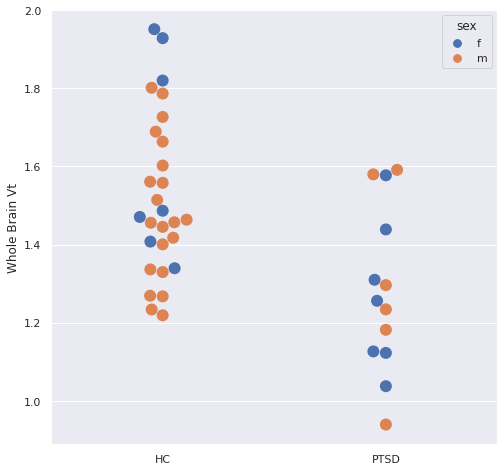

In [16]:
sns.swarmplot(x = 'group', y = 'whole_brain', data = wb, hue="sex", s=12).set(xlabel=None, ylabel="Whole Brain Vt")

There is a strong reduction in the expression of CB1r in the PTSD group. This is controlling for both age and sex.

To verify this result and look at the contribution of age and sex, 3 OLS models were used. 

Using AIC and BIC to compare models we will asses the fit to the data.



### some extra plot to show age / sex / and CB1r

In [17]:
norm = matplotlib.colors.Normalize(vmin=wb["age"].min(), vmax=wb["age"].max())
colors = {}
cmap = sns.diverging_palette(240, 10, as_cmap=True, center="dark")

for cval in wb["age"]:
    colors.update({cval : cmap(norm(cval))})

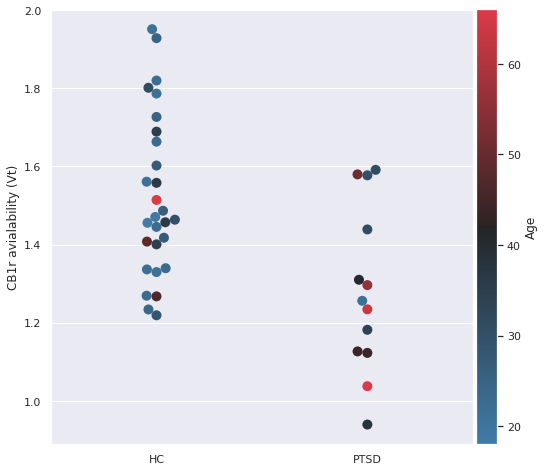

In [18]:
fig, ax = plt.subplots(figsize=(8,8))

sns.swarmplot(x = 'group', y = 'whole_brain', data = wb, hue = 'age', ax=ax,
              palette = colors, s=10).set(xlabel=None, ylabel="CB1r avialability (Vt)")

ax.legend_.remove()
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()

/home/nachshon/anaconda3/envs/cb1scr/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


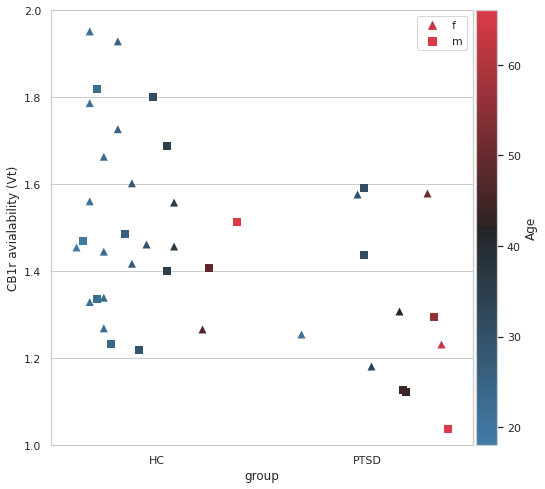

In [20]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")

fig, ax = plt.subplots(1,1)
# dummy plots, just to get the Path objects
a = ax.scatter([1,2],[3,4], marker='s')
b = ax.scatter([1,2],[3,4], marker='^')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()

ax = sns.swarmplot(x="group", y="whole_brain",data=wb,size=8,hue = 'age', ax=ax,
              palette = colors, dodge=True)
N_hues = len(pd.unique(wb.sex))

c = ax.collections
for a in c[::N_hues]:
    a.set_paths([triangle_up_mk])
for a in c[1::N_hues]:
    a.set_paths([square_mk])
#update legend
ax.legend(c[-2:],pd.unique(wb.sex))
ax.set(ylim=(1,2),ylabel="CB1r avialability (Vt)")
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()



## OLS analysis


In [21]:
m1 = smf.ols(formula='whole_brain ~ group', data=wb)
m2 = smf.ols(formula='whole_brain ~ group + age', data=wb)
m3 = smf.ols(formula='whole_brain ~ group + age + sex', data=wb)
    
m1f = m1.fit()
m2f = m2.fit()
m3f = m3.fit()

In [22]:
print(m1f.summary())
print(m2f.summary())
print(m3f.summary())

                            OLS Regression Results                            
Dep. Variable:            whole_brain   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     11.55
Date:                Fri, 04 Feb 2022   Prob (F-statistic):            0.00157
Time:                        16:06:43   Log-Likelihood:                 7.1492
No. Observations:                  41   AIC:                            -10.30
Df Residuals:                      39   BIC:                            -6.871
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5215      0.039     38.634

All models show a significant reduction in CB1r in the PTSD group p< 0.002-0.017. 

While the model without age or sex shows the best fit to the data, age is correlated with Vt and should be consider as an important covariate.

## Correlation between Whole brain CB1r availability and PTSD symptoms

In [23]:
pg.partial_corr(data=PTSD, x='whole_brain', y ='Total', covar=['age'])

,n,r,CI95%,p-val
pearson,13,0.215866,"[-0.41, 0.7]",0.500419


No significant correlation between global signal and PTSD symptoms

## Correlation between Amygdala CB1r and PTSD symptoms

as an a-priori analysis we choose to focus on the Amygdala. 

In [24]:
pg.partial_corr(data=PTSD, x='amygdala', y ='Total', covar=['age', 'whole_brain'])

,n,r,CI95%,p-val
pearson,13,0.609846,"[0.02, 0.89]",0.04635


There is a correlation between CB1r availability in the Amygdala and PTSD symptoms.

This is a positive correlation and it suggest that higher availability is linked to worst outcome.

Taken together with the overall reduction in CB1r, it suggest that the reduced CB1r is a compensatory mechanism. 

Thus, failure to down regulate CB1r in the Amygdala results in aberrant functioning.

In our analysis we partialled out the global signal, hence, we are looking at the CB1r in amygdala compared to the other regions of the brain. We show that the higher the amygdala to brain ratio is the worst the outcome.

<AxesSubplot:xlabel='Amygdala Vt', ylabel='Totsl Symptoms'>

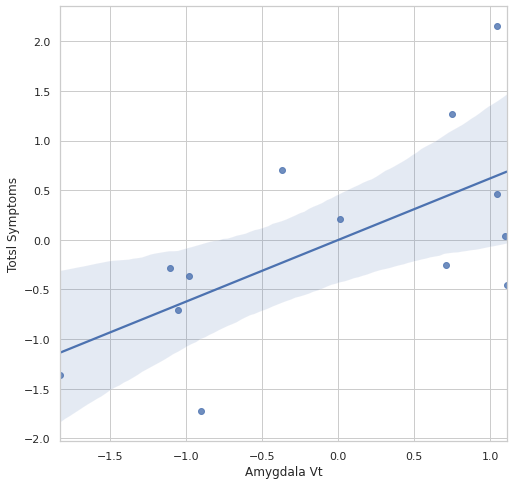

In [25]:
X = PTSD[['whole_brain', 'age']]   # independent variables
y = PTSD['amygdala']   # dependent variables

# add intercept
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit() 
influence = model.get_influence()

PTSD['Amygdala Vt'] = influence.resid_studentized_internal

X = PTSD[[ 'whole_brain', 'age']]   # independent variables
y = PTSD['Total']   # dependent variables

# add intercept
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit() 
influence = model.get_influence()

PTSD['Totsl Symptoms'] = influence.resid_studentized_internal

sns.regplot(x = 'Amygdala Vt', y = 'Totsl Symptoms', data = PTSD)